In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pysal.explore import esda
from esda.moran import Moran, Moran_Local
from pysal.lib import weights
from shapely.ops import unary_union

/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:198: NumbaDeprecationWarning: The 'nopython' keyw

In [2]:
## Load Data

gdf_lsoa = gpd.read_file("Data/manchester_lsoa/manchester_lsoa.shp")
gdf_supply_demand = gpd.read_file("Data/supply_demand_sorted/pt_supply_demand_sorted.shp")
drt_zones = gpd.read_file("Data/LocalLink_MapData/SHP-format/Locallink_Areas.shp")

In [3]:
gdf_supply_demand

,lsoa21cd,nearest_st,bus_stops_,pt_supply,women_perc,elderly_pe,child_perc,pop_dens_n,dis_nc_nor,deprived_p,pt_demand,pt_supply_,pt_demand_,demand_sup,diff_rank,geometry
0,E01005610,0.052838,0.079558,0.066198,0.787601,0.851961,0.195232,4.401270e-10,0.704446,0.769665,0.551484,0.126603,0.956331,0.829728,1,"POLYGON ((382382.589 399864.740, 382401.425 39..."
1,E01005754,0.049804,0.065530,0.057667,0.167110,0.369347,0.418846,4.532650e-10,0.979153,0.955373,0.481638,0.110287,0.835211,0.724923,2,"POLYGON ((390607.548 393101.450, 390611.942 39..."
2,E01005210,0.097718,0.208716,0.153217,0.854690,0.892292,0.163253,1.198325e-09,0.792819,0.756947,0.576667,0.293025,1.000000,0.706975,3,"POLYGON ((384153.632 396891.980, 384161.000 39..."
3,E01005756,0.021442,0.030377,0.025910,0.199149,0.334398,0.493663,3.885690e-10,0.762277,0.792640,0.430354,0.049552,0.746279,0.696727,4,"POLYGON ((390827.813 393516.000, 390829.198 39..."
4,E01033949,0.078052,0.077222,0.077637,0.236430,0.375917,0.376284,8.482980e-10,0.895783,1.000000,0.480736,0.148480,0.833646,0.685166,5,"POLYGON ((393444.877 399091.062, 393433.243 39..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1697,E01005014,0.935469,0.084649,0.510059,0.110607,0.677836,0.274645,2.498270e-10,0.235853,0.196151,0.249182,0.975480,0.432107,-0.543373,1698,"POLYGON ((378829.600 417749.600, 378844.350 41..."
1698,E01006347,0.855281,0.151594,0.503437,0.094869,0.706653,0.307677,4.129550e-10,0.158103,0.115053,0.230393,0.962817,0.399525,-0.563292,1699,"POLYGON ((362235.020 397630.850, 362238.884 39..."
1699,E01006303,1.000000,0.025927,0.512964,0.139693,0.613296,0.312330,6.595200e-11,0.128974,0.234639,0.238155,0.981036,0.412986,-0.568050,1700,"POLYGON ((363350.507 399570.265, 363351.812 39..."
1700,E01006302,0.993466,0.016334,0.504900,0.152892,0.476264,0.345128,1.877420e-10,0.127994,0.266121,0.228066,0.965614,0.395491,-0.570123,1701,"POLYGON ((364308.400 397256.400, 364288.885 39..."


Text(0.5, 1.0, 'Supply-Demand Index Distribution')

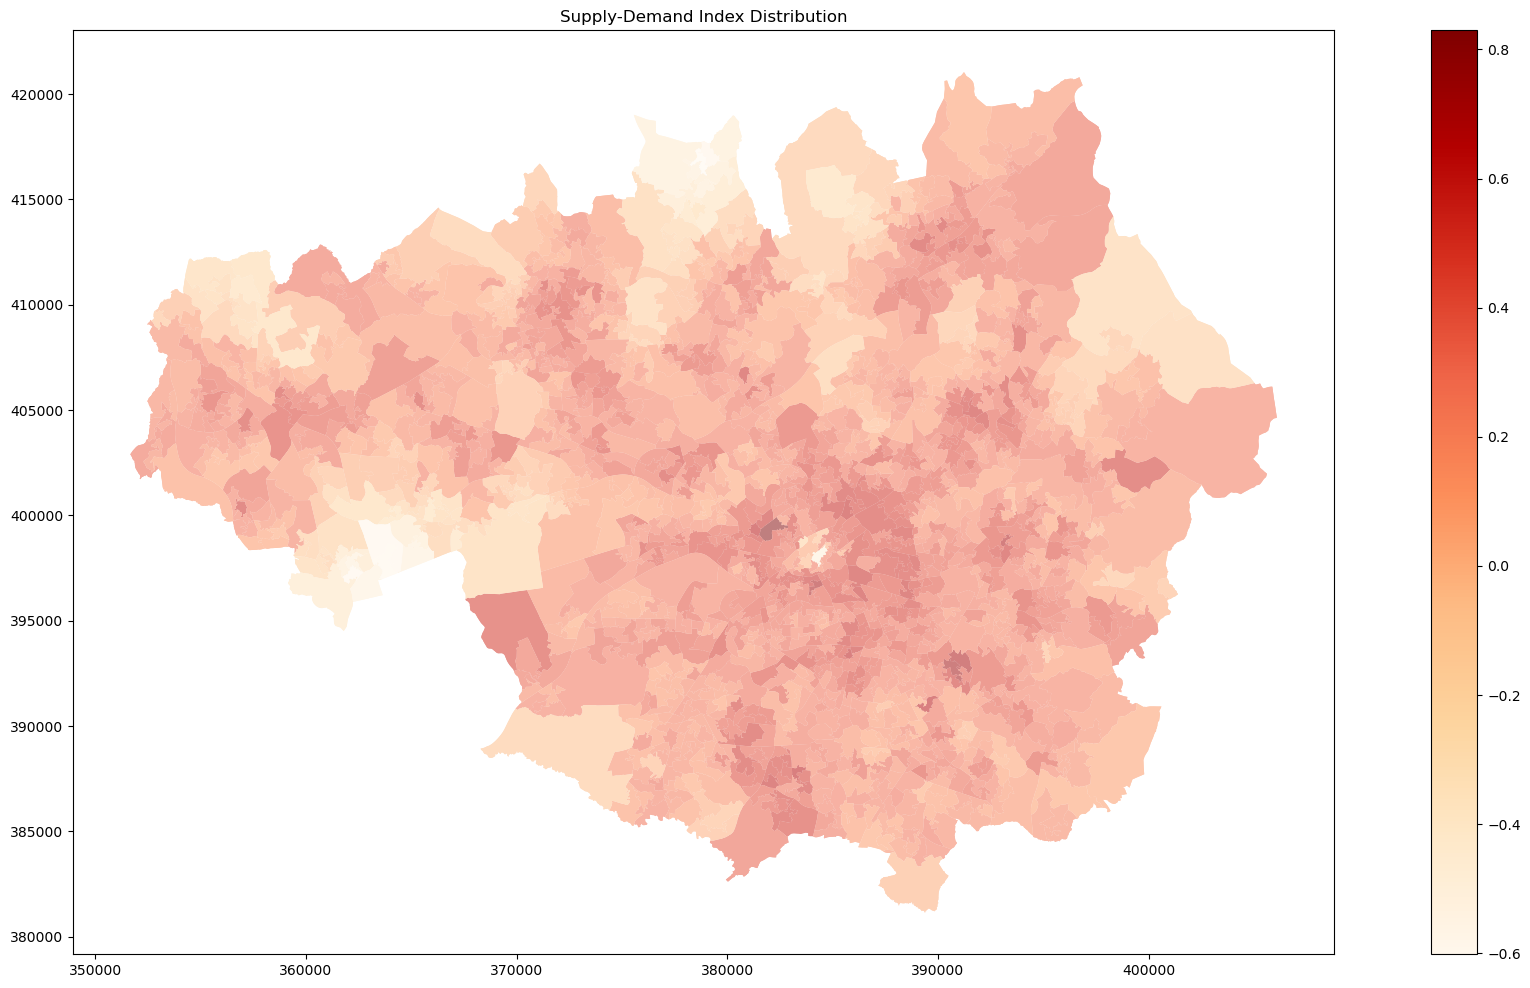

In [4]:
fig, axes = plt.subplots(1,1 , figsize=(25, 12))

gdf_supply_demand.plot(ax=axes, column="demand_sup", cmap="OrRd", legend=True)
gdf_lsoa.plot(ax=axes, facecolor="white", alpha=0.5, edgecolor="none", linewidth=0.5)
axes.set_title("Supply-Demand Index Distribution")

## Global Moran's I

In [5]:
## Defining Weight
w = weights.Queen.from_dataframe(gdf_supply_demand)
w.transform = "r"

In [6]:
## Calculate Global Moran's I
y = gdf_supply_demand["demand_sup"].values
moran = Moran(y,w)

print(f"Moran's I: {moran.I}")
print(f"Expected value: {moran.EI}")
print(f"Variance: {moran.VI_norm}")
print(f"Z-score: {moran.z_norm}")
print(f"P-value: {moran.p_norm}")

Moran's I: 0.6990811444821511
Expected value: -0.0005878894767783657
Variance: 0.0002066388787452283
Z-score: 48.672834109139
P-value: 0.0


## Local Moran's I

In [7]:
## Calculate Local Moran's I for each LSOA
moran_local = Moran_Local(y,w)

## Create new column to store the local moran's I value and its p_value
gdf_supply_demand["local_moran"] = moran_local.Is
gdf_supply_demand["local_moran_p"] = moran_local.p_sim

In [8]:
gdf_supply_demand

,lsoa21cd,nearest_st,bus_stops_,pt_supply,women_perc,elderly_pe,child_perc,pop_dens_n,dis_nc_nor,deprived_p,pt_demand,pt_supply_,pt_demand_,demand_sup,diff_rank,geometry,local_moran,local_moran_p
0,E01005610,0.052838,0.079558,0.066198,0.787601,0.851961,0.195232,4.401270e-10,0.704446,0.769665,0.551484,0.126603,0.956331,0.829728,1,"POLYGON ((382382.589 399864.740, 382401.425 39...",3.597357,0.001
1,E01005754,0.049804,0.065530,0.057667,0.167110,0.369347,0.418846,4.532650e-10,0.979153,0.955373,0.481638,0.110287,0.835211,0.724923,2,"POLYGON ((390607.548 393101.450, 390611.942 39...",3.528574,0.001
2,E01005210,0.097718,0.208716,0.153217,0.854690,0.892292,0.163253,1.198325e-09,0.792819,0.756947,0.576667,0.293025,1.000000,0.706975,3,"POLYGON ((384153.632 396891.980, 384161.000 39...",2.698053,0.003
3,E01005756,0.021442,0.030377,0.025910,0.199149,0.334398,0.493663,3.885690e-10,0.762277,0.792640,0.430354,0.049552,0.746279,0.696727,4,"POLYGON ((390827.813 393516.000, 390829.198 39...",2.760545,0.003
4,E01033949,0.078052,0.077222,0.077637,0.236430,0.375917,0.376284,8.482980e-10,0.895783,1.000000,0.480736,0.148480,0.833646,0.685166,5,"POLYGON ((393444.877 399091.062, 393433.243 39...",3.069840,0.003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1697,E01005014,0.935469,0.084649,0.510059,0.110607,0.677836,0.274645,2.498270e-10,0.235853,0.196151,0.249182,0.975480,0.432107,-0.543373,1698,"POLYGON ((378829.600 417749.600, 378844.350 41...",18.290782,0.001
1698,E01006347,0.855281,0.151594,0.503437,0.094869,0.706653,0.307677,4.129550e-10,0.158103,0.115053,0.230393,0.962817,0.399525,-0.563292,1699,"POLYGON ((362235.020 397630.850, 362238.884 39...",17.612646,0.001
1699,E01006303,1.000000,0.025927,0.512964,0.139693,0.613296,0.312330,6.595200e-11,0.128974,0.234639,0.238155,0.981036,0.412986,-0.568050,1700,"POLYGON ((363350.507 399570.265, 363351.812 39...",15.904359,0.001
1700,E01006302,0.993466,0.016334,0.504900,0.152892,0.476264,0.345128,1.877420e-10,0.127994,0.266121,0.228066,0.965614,0.395491,-0.570123,1701,"POLYGON ((364308.400 397256.400, 364288.885 39...",19.187622,0.001


In [9]:
## Set significance level
significance_level = 0.05

## Identify significant clusters and outliers
gdf_supply_demand["significant"] = gdf_supply_demand["local_moran_p"] < significance_level

## Differentiate between high-high, low-low, high-low, and low-high clusters
gdf_supply_demand["cluster_type"] = "Not Significant"
gdf_supply_demand.loc[(gdf_supply_demand["significant"]) & (gdf_supply_demand["local_moran"] > 0) & (y > y.mean()), "cluster_type"] = "High-High"
gdf_supply_demand.loc[(gdf_supply_demand["significant"]) & (gdf_supply_demand["local_moran"] > 0) & (y < y.mean()), "cluster_type"] = "Low-Low"
gdf_supply_demand.loc[(gdf_supply_demand["significant"]) & (gdf_supply_demand["local_moran"] < 0) & (y > y.mean()), "cluster_type"] = "High-Low"
gdf_supply_demand.loc[(gdf_supply_demand["significant"]) & (gdf_supply_demand["local_moran"] < 0) & (y < y.mean()), "cluster_type"] = "Low-High"

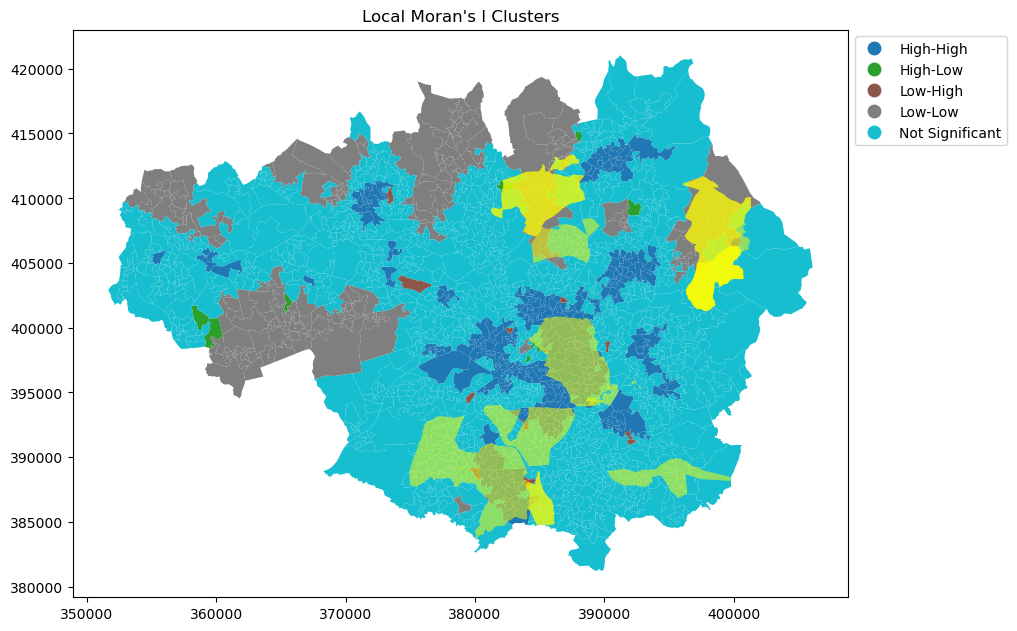

In [14]:
# Plot the clusters
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf_supply_demand.plot(ax=ax, column="cluster_type", categorical=True, legend=True,
         legend_kwds={"bbox_to_anchor": (1, 1), "loc": "upper left"})

drt_zones.plot(ax=ax, facecolor="yellow", alpha=0.5)
plt.title("Local Moran\'s I Clusters")
plt.show()

## Extract High-High Areas

In [11]:
## Filter only High-High areas
high_high = gdf_supply_demand[gdf_supply_demand["cluster_type"] == "High-High"]

In [12]:
## Merge neighboring High-High areas into single polygons
high_high_union = high_high.geometry.unary_union

In [33]:
## Create a new gdf from the merged High-High areas
high_high_zones = gpd.GeoDataFrame(geometry=[high_high_union], crs=gdf_supply_demand.crs)
high_high_zones.to_file("Data/proposed_zones/high_high.shp")